# 使用AlexNet卷积神经网络来分类CIFAR10库

AlexNet是Hinton和他的学生Alex Krizhevsky设计的，并且在2012年的ImageNet竞赛中获得冠军。AlexNet在LeNet的基础上加深了网络的结构，能够学习更丰富更高维的图像特征。AlexNet网络具有以下特点：
* 更深的网络结构
* 使用层叠的卷积层，即卷积层+卷积层+池化层来提取图像的特征
* 使用Dropout抑制过拟合
* 使用数据增强Data Augmentation抑制过拟合
* 使用Relu替换以前常用的sigmoid的作为激活函数
* 多GPU训练

In [6]:
# -*- coding:utf-8 -*-
import os
import time
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

<img src="../image/alexnet.png" alt="Drawing" style="width: 700px;" align="center"/>

AlexNet的网络结构如上图所示。下面用Pytorch的基本函数来搭建一个AlexNet。

In [7]:
class AlexNet(nn.Module):
    def __init__(self, ouput_size):
        super(AlexNet, self).__init__()

        self.conv1 = nn.Sequential( 
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.ReLU(inplace=True)
            )

        self.conv2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.ReLU(inplace=True)
            )

        self.conv3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True)
            )

        self.conv4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True)
            )
 
        self.conv5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1), 
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.ReLU(inplace=True)
            )

        self.fc1 = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256*6*6, 4096),
            nn.ReLU()
            )

        self.fc2 = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU()
            )

        self.fc3 = nn.Sequential(
            nn.Linear(4096, ouput_size),
            nn.LogSoftmax(dim=-1)
            )


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

CIFAR-10数据集 是由 Hinton 的学生 Alex Krizhevsky 和 Ilya Sutskever 整理的一个用于识别普适物体的小型数据集。一共包含 10 个类别的 RGB 彩色图 片：飞机（ airplane ）、汽车（ automobile ）、鸟类（ bird ）、猫（ cat ）、鹿（ deer ）、狗（ dog ）、蛙类（ frog ）、马（ horse ）、船（ ship ）和卡车（ truck ）。图片的尺寸为 32×32 ，数据集中一共有 50000 张训练图片和 10000 张测试图片。

In [8]:
def load_data(root, batch_size):
    image_size = 227
    data_tf = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)), 
        transforms.ToTensor( ),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    train_data = datasets.CIFAR10(root=root,train=True,transform=data_tf,download=False)
    valid_data = datasets.CIFAR10(root=root,train=False,transform=data_tf,download=False)

    train_loader =torch.utils.data.DataLoader(dataset=train_data,batch_size=batch_size,shuffle=True)
    valid_loader =torch.utils.data.DataLoader(dataset=valid_data,batch_size=batch_size,shuffle=False)
    return train_loader, valid_loader

定义train函数

In [9]:
def train(train_loader, valid_loader, learning_rate, epochs):
    model = AlexNet(ouput_size = 10).to(device)

    # create a stochastic gradient descent optimizer
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
        
    # create a loss function
    criterion = nn.CrossEntropyLoss()

    start_time = time.time()
    total_loss = []
    for epoch in range(epochs):
        model.train()
        
        train_loss, train_accs = [], []
        for _, (data, target) in enumerate(train_loader):
            data = data.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            result = model(data)
            loss = criterion(result, target)
            loss.backward()
            optimizer.step()

            accuarcy = (result.argmax(dim=-1).to('cpu') == target.to('cpu')).float().mean()  
            train_loss.append(loss.item())
            train_accs.append(accuarcy)

        train_loss = sum(train_loss) / len(train_loss)
        train_acc = sum(train_accs) /len(train_accs)
        print(f"[ Train | {epoch + 1:03d}/{epochs:03d} ] loss = {train_loss:.5f}, accuracy = {train_acc:.5f}")    
        
        # begin valid
        model.eval() 
        valid_loss, valid_accs = [], []
     
        for data, target in valid_loader:
            data = data.to(device)
            target = target.to(device)
            with torch.no_grad():
                result = model(data)

            loss = criterion(result, target)
            accuarcy = (result.argmax(dim=-1).to('cpu') == target.to('cpu')).float().mean()

            valid_loss.append(loss.item())
            valid_accs.append(accuarcy) 

        valid_loss = sum(valid_loss) / len(valid_loss)
        valid_acc = sum(valid_accs) / len(valid_accs)
        total_loss.append(valid_loss)
        print(f"[ Valid | {epoch + 1:03d}/{epochs:03d} ] loss = {valid_loss:.5f}, accuracy = {valid_acc:.5f}")

    time_span = time.time() - start_time
    print(f'Training is over, spending time {time_span/60:.1f} minutes \r\nvalid accuracy is {valid_acc:.5f}')
    return total_loss

开始训练

[ Train | 001/010 ] loss = 1.63486, accuracy = 0.39124
[ Valid | 001/010 ] loss = 1.40671, accuracy = 0.51224
[ Train | 002/010 ] loss = 1.15944, accuracy = 0.58632
[ Valid | 002/010 ] loss = 1.02781, accuracy = 0.64122
[ Train | 003/010 ] loss = 0.91191, accuracy = 0.67717
[ Valid | 003/010 ] loss = 0.84051, accuracy = 0.70920
[ Train | 004/010 ] loss = 0.76261, accuracy = 0.73426
[ Valid | 004/010 ] loss = 0.76028, accuracy = 0.74512
[ Train | 005/010 ] loss = 0.65692, accuracy = 0.77092
[ Valid | 005/010 ] loss = 0.68354, accuracy = 0.76752
[ Train | 006/010 ] loss = 0.57203, accuracy = 0.80273
[ Valid | 006/010 ] loss = 0.55406, accuracy = 0.81320
[ Train | 007/010 ] loss = 0.49759, accuracy = 0.82685
[ Valid | 007/010 ] loss = 0.57933, accuracy = 0.80732
[ Train | 008/010 ] loss = 0.44240, accuracy = 0.84653
[ Valid | 008/010 ] loss = 0.52399, accuracy = 0.82643
[ Train | 009/010 ] loss = 0.38700, accuracy = 0.86467
[ Valid | 009/010 ] loss = 0.51088, accuracy = 0.82663
[ Train | 

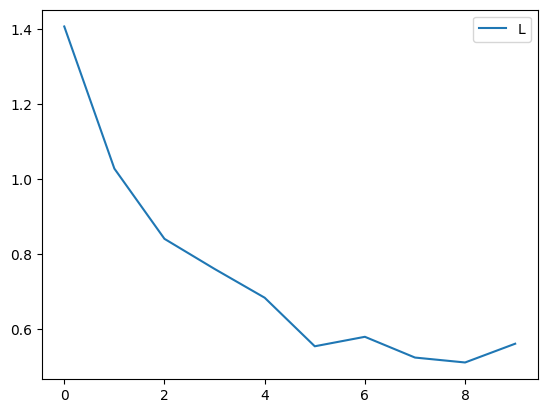

In [10]:
def main():
    data_root = Path(os.environ.get('ML_DATA_ROOT')).joinpath('cifar-10-python')
    train_loader, valid_loader = load_data(data_root, batch_size = 64);
    losses = train(train_loader, valid_loader, learning_rate = 0.005, epochs = 10)

    # 绘制损失函数曲线
    plt.figure('AlexNet')
    plt.plot(losses, label='Loss')
    plt.legend('Loss')
    plt.show()

if __name__ == "__main__":
    main()